In [1]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary
from torch.optim import lr_scheduler
import copy

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image
from collections import OrderedDict
import shutil 

In [2]:
# Move images so that dataloader can handle it
class_maps = OrderedDict()
with open('./data/tiny-imagenet-200/val/val_annotations.txt', "r") as f:
    for line in f:
        one_line = line.split()
        class_maps[one_line[0]] = one_line[1]
# print(class_maps)

val_path = './data/tiny-imagenet-200/val/'
for image, class_name in class_maps.items():
    if not os.path.exists(val_path+'{}'.format(class_name)):
        try:
            os.makedirs(val_path+'{}/images'.format(class_name))
        except OSError as e:
            raise e
    if os.path.exists(val_path+'images'):
        source = val_path + 'images/{}'.format(image)
        destination = val_path + '{}/images/'.format(class_name)
        shutil.move(source, destination)

# remove the original image directory
if os.path.exists(val_path+'images'):
    os.rmdir(val_path + 'images')

In [3]:
# Load the Data
data_dir = './data/tiny-imagenet-200'
num_classes = 200

# Create the training data generator
batch_size = 32
im_height = 64
im_width = 64
num_epochs = 1

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), tuple(np.sqrt((255, 255, 255)))),
])

# Load Data from folders
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=data_transforms),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=data_transforms),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=data_transforms)
}

phases = ['train', 'val', 'test']
num_workers = {
    'train' : 0,
    'val'   : 0,
    'test'  : 0
}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers[x]) for x in phases}
dataset_sizes = {x: len(image_datasets[x]) for x in phases}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

{'train': 100000, 'val': 10000, 'test': 10000}


In [25]:
# for inputs, labels in dataloaders['val']:
#     print(labels)
#     break

In [29]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    tr_acc, val_acc = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
#                 print(preds[:20])
#                 print(labels.data[:20])
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                tr_acc.append(epoch_acc)
            elif phase == 'val':
                val_acc.append(epoch_acc)
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, tr_acc, val_acc

In [24]:
# Load the pretrained model
model = models.resnet18(pretrained=True)

# Freeze model parameters to train only the last layer. 
# Comment out this cell if you want to fine tune the whole network
# for param in model.parameters():
#     param.requires_grad = False

In [25]:
# Change the final layer to fit 200 classes (Transfer Learning)
num_ftrs = model.fc.in_features
# model.fc = nn.Sequential(
#     nn.Linear(fc_inputs, 256),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(256, num_classes),
#     nn.LogSoftmax(dim=1) # For using NLLLoss()
# )
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
# Define Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
# learning_rates = [0.00001, 0.0001, 0.001]
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
model, tr_acc, val_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 3.6905 Acc: 0.1796
val Loss: 3.2401 Acc: 0.2418

Epoch 1/9
----------
train Loss: 2.9219 Acc: 0.3066
val Loss: 2.8574 Acc: 0.3201

Epoch 2/9
----------
train Loss: 2.5039 Acc: 0.3879
val Loss: 2.7000 Acc: 0.3709

Epoch 3/9
----------
train Loss: 2.1565 Acc: 0.4573
val Loss: 3.4735 Acc: 0.2834

Epoch 4/9
----------
train Loss: 1.8196 Acc: 0.5286
val Loss: 2.5971 Acc: 0.4002

Epoch 5/9
----------
train Loss: 0.9916 Acc: 0.7257
val Loss: 2.9134 Acc: 0.4372

Epoch 6/9
----------
train Loss: 0.7121 Acc: 0.7957
val Loss: 2.9663 Acc: 0.4410

Epoch 7/9
----------
train Loss: 0.5288 Acc: 0.8430
val Loss: 3.3291 Acc: 0.4246

Epoch 8/9
----------
train Loss: 0.3894 Acc: 0.8826
val Loss: 3.8035 Acc: 0.4209

Epoch 9/9
----------
train Loss: 0.2846 Acc: 0.9127
val Loss: 4.1252 Acc: 0.4147

Training complete in 70m 31s
Best val Acc: 0.441000


In [30]:
torch.save(model, './models/resnet18_model.pt')

In [26]:
vgg_model = models.vgg11_bn(pretrained=True)
# for param in vgg_model.parameters():
#     param.requires_grad = False
vgg_model = vgg_model.to(device)
num_ftrs = vgg_model.classifier[6].in_features
vgg_model.classifier[6] = nn.Linear(num_ftrs,num_classes)
vgg_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [32]:
vgg_model.fc = nn.Linear(num_ftrs, num_classes)
vgg_model = vgg_model.to(device)
criterion = nn.CrossEntropyLoss()
# optimizer_ft = optim.Adam(vgg_model.parameters(), lr=0.01)
optimizer_ft = optim.SGD(vgg_model.parameters(), lr=0.01, momentum=0.9)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)
vgg_model, vgg_tr_acc, vgg_val_acc = train_model(vgg_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 20.7110 Acc: 0.3433
val Loss: 15.1388 Acc: 0.4191

Epoch 1/9
----------
train Loss: 19.3294 Acc: 0.3496
val Loss: 15.0551 Acc: 0.4211

Epoch 2/9
----------
train Loss: 18.3038 Acc: 0.3524
val Loss: 13.6953 Acc: 0.4213

Epoch 3/9
----------
train Loss: 17.3721 Acc: 0.3544
val Loss: 13.0286 Acc: 0.4213

Epoch 4/9
----------
train Loss: 16.6206 Acc: 0.3586
val Loss: 12.6725 Acc: 0.4221

Epoch 5/9
----------
train Loss: 15.7441 Acc: 0.3620
val Loss: 12.7543 Acc: 0.4203

Epoch 6/9
----------
train Loss: 15.2020 Acc: 0.3652
val Loss: 11.9724 Acc: 0.4247

Epoch 7/9
----------
train Loss: 14.4691 Acc: 0.3666
val Loss: 11.8389 Acc: 0.4265

Epoch 8/9
----------
train Loss: 14.0543 Acc: 0.3674
val Loss: 11.4576 Acc: 0.4203

Epoch 9/9
----------
train Loss: 13.5160 Acc: 0.3687
val Loss: 10.8839 Acc: 0.4233

Training complete in 24m 56s
Best val Acc: 0.426500


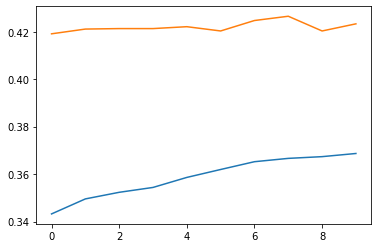

In [33]:
torch.save(model, './models/vgg11_bn_SGD_model.pt')
# plt.plot(vgg_tr_acc)
# plt.plot(vgg_val_acc)

In [9]:
model_ft = models.squeezenet1_0(pretrained=True)
model_ft = inc_model.to(device)
model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
model_ft.num_classes = num_classes
inc_model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [ ]:
# inc_model.fc = nn.Linear(num_ftrs, num_classes)
# inc_model = inc_model.to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer_ft = optim.Adam(inc_model.parameters(), lr=0.01)
# # optimizer_ft = optim.SGD(inc_model.parameters(), lr=0.01, momentum=0.9)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)
# inc_model, vgg_tr_acc, vgg_val_acc = train_model(inc_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)